In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import zhinst.toolkit as tk

In [2]:
mdc = tk.MultiDeviceConnection()
mdc.setup()

Successfully connected to data server at localhost8004 api version: 6


In [3]:
hd = tk.HDAWG("hd", "dev8030", interface="1GbE")
qa = tk.UHFQA("qa", "dev2266", interface="1GbE")

In [4]:
mdc.connect_device(hd)
mdc.connect_device(qa)

Successfully connected to device DEV8030 on interface 1GBE
Successfully connected to device DEV2266 on interface 1GBE


# Rabi: vary pulse amplitude

Use HDAWG awg 1 to send qubit drive pulse and trigger UHFQA Readout.

In [5]:
averages = 2**3
period = 100e-6

drive_freq = 78.54e6
rabi_amplitudes = np.linspace(0.1, 1.0, 100)

int_time = 2e-6

In [6]:
# enable IQ modulation of HDAWG
hd.awgs[0].enable_iq_modulation()
hd.awgs[0].modulation_freq(drive_freq)
hd.awgs[0].gain1(1)
hd.awgs[0].gain2(0.1)
# hd.nodetree.system.awg.oscillatorcontrol(1)

# prepare sequence on HDAWG
hd.awgs[0].set_sequence_params(
    sequence_type="Rabi",
    repetitions=averages,
    period=period,
    alignment="Start with Trigger",
    trigger_mode="Send Trigger",
    pulse_width=20e-9,
    pulse_truncation=4,
)

# set parameter 'pulse_amplitudes' for hardware-looped Rabi
hd.awgs[0].set_sequence_params(pulse_amplitudes=rabi_amplitudes)

hd.awgs[0].compile()

Compilation successful
hd-0: Sequencer status: ELF file uploaded


In [7]:
hd.awgs[0]

hd: <zhinst.toolkit.hdawg.AWG object at 0x00000185FD31B390>
    parent  : <zhinst.toolkit.hdawg.HDAWG object at 0x00000185FD31B208>
    index   : 0
    sequence: 
           type: Rabi
            ('target', 'hdawg')
            ('clock_rate', 2400000000.0)
            ('period', 0.0001)
            ('trigger_mode', 'Send Trigger')
            ('repetitions', 8)
            ('alignment', 'Start with Trigger')
            ('n_HW_loop', 100)
            ('dead_time', 5e-06)
            ('trigger_delay', 0)
            ('latency', 1.6e-07)
            ('trigger_cmd_1', 'setTrigger(1);\n')
            ('trigger_cmd_2', 'setTrigger(0);\n')
            ('wait_cycles', 28500)
            ('dead_cycles', 1452.0)
            ('reset_phase', True)
            ('pulse_amplitudes', array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364,

In [8]:
qa.awg.set_sequence_params(
    sequence_type="Readout",
    repetitions=averages * len(rabi_amplitudes),
    period=period,
    alignment="Start with Trigger",
    trigger_mode="External Trigger",
    readout_length=int_time,
    trigger_delay=-30e-9,
)

# prepare readout channel on UHFQA
qa.integration_time(int_time)
qa.channels[0].enable()
qa.channels[0].readout_frequency(drive_freq)
qa.channels[0].rotation(0)

qa.awg.compile()

Compilation successful
qa-0: Sequencer status: ELF file uploaded


In [9]:
hd.awgs[0].outputs("on")
qa.awg.outputs("off")

In [10]:
# configure result acquisition

qa.result_source("integration")
qa.nodetree.qa.result.length(len(rabi_amplitudes)*averages)
qa.nodetree.qa.result.averages(1)
qa.nodetree.qa.result.enable(1)
qa.nodetree.qa.result.reset(0)
qa.nodetree.qa.result.reset(1)

1

In [13]:
# acquire data only at the end of the measurement
tik = time.time()

qa.awg.run()
time.sleep(0.1)
hd.awgs[0].run()
hd.awgs[0].wait_done(timeout=100)
    
res = qa.channels[0].result()

print(time.time() - tik)

0.36176490783691406


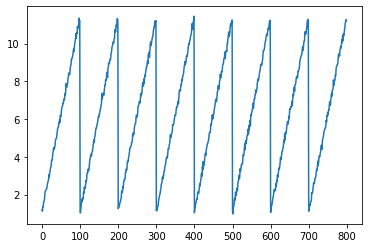

In [14]:
plt.plot(np.real(res))

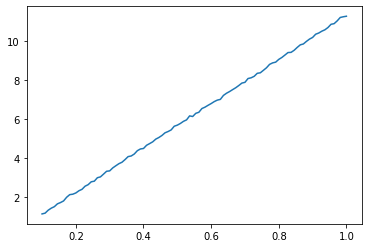

In [15]:
reshaped = np.real(res.reshape(averages, len(rabi_amplitudes)))
averaged = np.mean(reshaped, axis=0)

plt.plot(rabi_amplitudes, averaged)
plt.show()

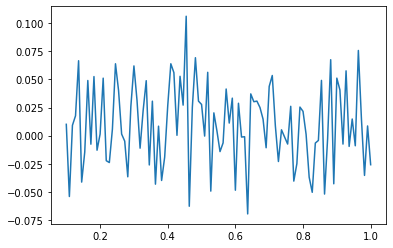

In [16]:
reshaped = np.imag(res.reshape(averages, len(rabi_amplitudes)))
averaged = np.mean(reshaped, axis=0)

plt.plot(rabi_amplitudes, averaged)
plt.show()

## Rabi: time-domain

In [20]:
averages = 2**3
period = 100e-6

drive_freq = 78.54e6
rabi_widths = np.linspace(0, 500e-9, 51)

int_time = 2e-6

In [36]:
# enable IQ modulation of HDAWG
hd.awgs[0].enable_iq_modulation()
hd.awgs[0].modulation_freq(drive_freq)
hd.awgs[0].gain1(1)
hd.awgs[0].gain2(0.1)
# hd.nodetree.system.awg.oscillatorcontrol(1)

# prepare sequence on HDAWG
hd.awgs[0].set_sequence_params(
    sequence_type="Simple",
    repetitions=averages,
    period=period,
    alignment="Start with Trigger",
    trigger_mode="Send Trigger",
)



In [37]:
def flat_top_gauss(flat_top, sigma, truncation=3, clk=2.4e9):
    flat_top = int(flat_top*clk)
    sigma = int(sigma*clk)
    x = np.arange(0, truncation*sigma, 1)
    gauss_fall = np.exp(-x**2/sigma**2)
    gauss_rise = np.flip(gauss_fall)
    flat = np.ones(flat_top)
    gauss = np.hstack((gauss_rise, flat))
    gauss = np.hstack((gauss, gauss_fall))
    return gauss

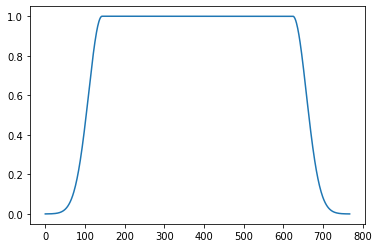

In [38]:
top = 200e-9
sigma = 20e-9
plt.plot(flat_top_gauss(top, sigma, truncation=3))
plt.show()

In [39]:
hd.awgs[0].reset_queue()
for top in rabi_widths:
    wave = flat_top_gauss(top, sigma)
    hd.awgs[0].queue_waveform(wave, [])
hd.awgs[0].compile_and_upload_waveforms()

Current length of queue: 1
Current length of queue: 2
Current length of queue: 3
Current length of queue: 4
Current length of queue: 5
Current length of queue: 6
Current length of queue: 7
Current length of queue: 8
Current length of queue: 9
Current length of queue: 10
Current length of queue: 11
Current length of queue: 12
Current length of queue: 13
Current length of queue: 14
Current length of queue: 15
Current length of queue: 16
Current length of queue: 17
Current length of queue: 18
Current length of queue: 19
Current length of queue: 20
Current length of queue: 21
Current length of queue: 22
Current length of queue: 23
Current length of queue: 24
Current length of queue: 25
Current length of queue: 26
Current length of queue: 27
Current length of queue: 28
Current length of queue: 29
Current length of queue: 30
Current length of queue: 31
Current length of queue: 32
Current length of queue: 33
Current length of queue: 34
Current length of queue: 35
Current length of queue: 36
C

In [40]:
qa.awg.set_sequence_params(
    sequence_type="Readout",
    repetitions=averages * len(rabi_widths),
    period=period,
    alignment="Start with Trigger",
    trigger_mode="External Trigger",
    readout_length=int_time,
    trigger_delay=-30e-9,
)

# prepare readout channel on UHFQA
qa.integration_time(int_time)
qa.channels[0].enable()
qa.channels[0].readout_frequency(drive_freq)
qa.channels[0].rotation(0)

qa.awg.compile()

Compilation successful
qa-0: Sequencer status: ELF file uploaded


In [41]:
hd.awgs[0].outputs("on")
qa.awg.outputs("off")

In [42]:
# configure result acquisition

qa.result_source("integration")
qa.nodetree.qa.result.length(len(rabi_widths)*averages)
qa.nodetree.qa.result.averages(1)
qa.nodetree.qa.result.enable(1)
qa.nodetree.qa.result.reset(0)
qa.nodetree.qa.result.reset(1)

1

In [43]:
# acquire data only at the end of the measurement
tik = time.time()

qa.awg.run()
time.sleep(0.1)
hd.awgs[0].run()
hd.awgs[0].wait_done(timeout=100)
    
res = qa.channels[0].result()

print(time.time() - tik)

0.532059907913208


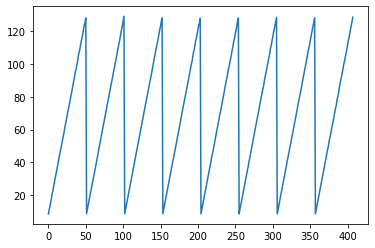

In [44]:
plt.plot(np.real(res))

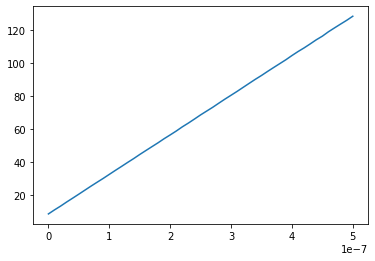

In [45]:
reshaped = np.real(res.reshape(averages, len(rabi_widths)))
averaged = np.mean(reshaped, axis=0)

plt.plot(rabi_widths, averaged)
plt.show()